# Noise Model Simulation: FakeGeneva

Running ideal simulation...

Measurement Probabilities (Ideal):
  State |000001>: 0.6382
  State |000010>: 0.2233
  State |000100>: 0.0914
  State |001000>: 0.0293
  State |010000>: 0.0130
  State |100000>: 0.0048

Running noisy simulation...

Measurement Probabilities (Noisy):
  State |000001>: 0.2793
  State |000010>: 0.1641
  State |000011>: 0.0544
  State |000100>: 0.1261
  State |000101>: 0.0394
  State |000110>: 0.0237
  State |000111>: 0.0105
  State |001000>: 0.0725
  State |001001>: 0.0174
  State |001010>: 0.0123
  State |001011>: 0.0052
  State |001100>: 0.0107
  State |001101>: 0.0067
  State |001110>: 0.0040
  State |001111>: 0.0010
  State |010000>: 0.0343
  State |010001>: 0.0080
  State |010010>: 0.0059
  State |010011>: 0.0013
  State |010100>: 0.0031
  State |010101>: 0.0010
  State |010110>: 0.0008
  State |011000>: 0.0123
  State |011001>: 0.0046
  State |011010>: 0.0027
  State |011011>: 0.0004
  State |011100>: 0.0019
  State |011110>: 0.0002
  State |011111>: 0.0

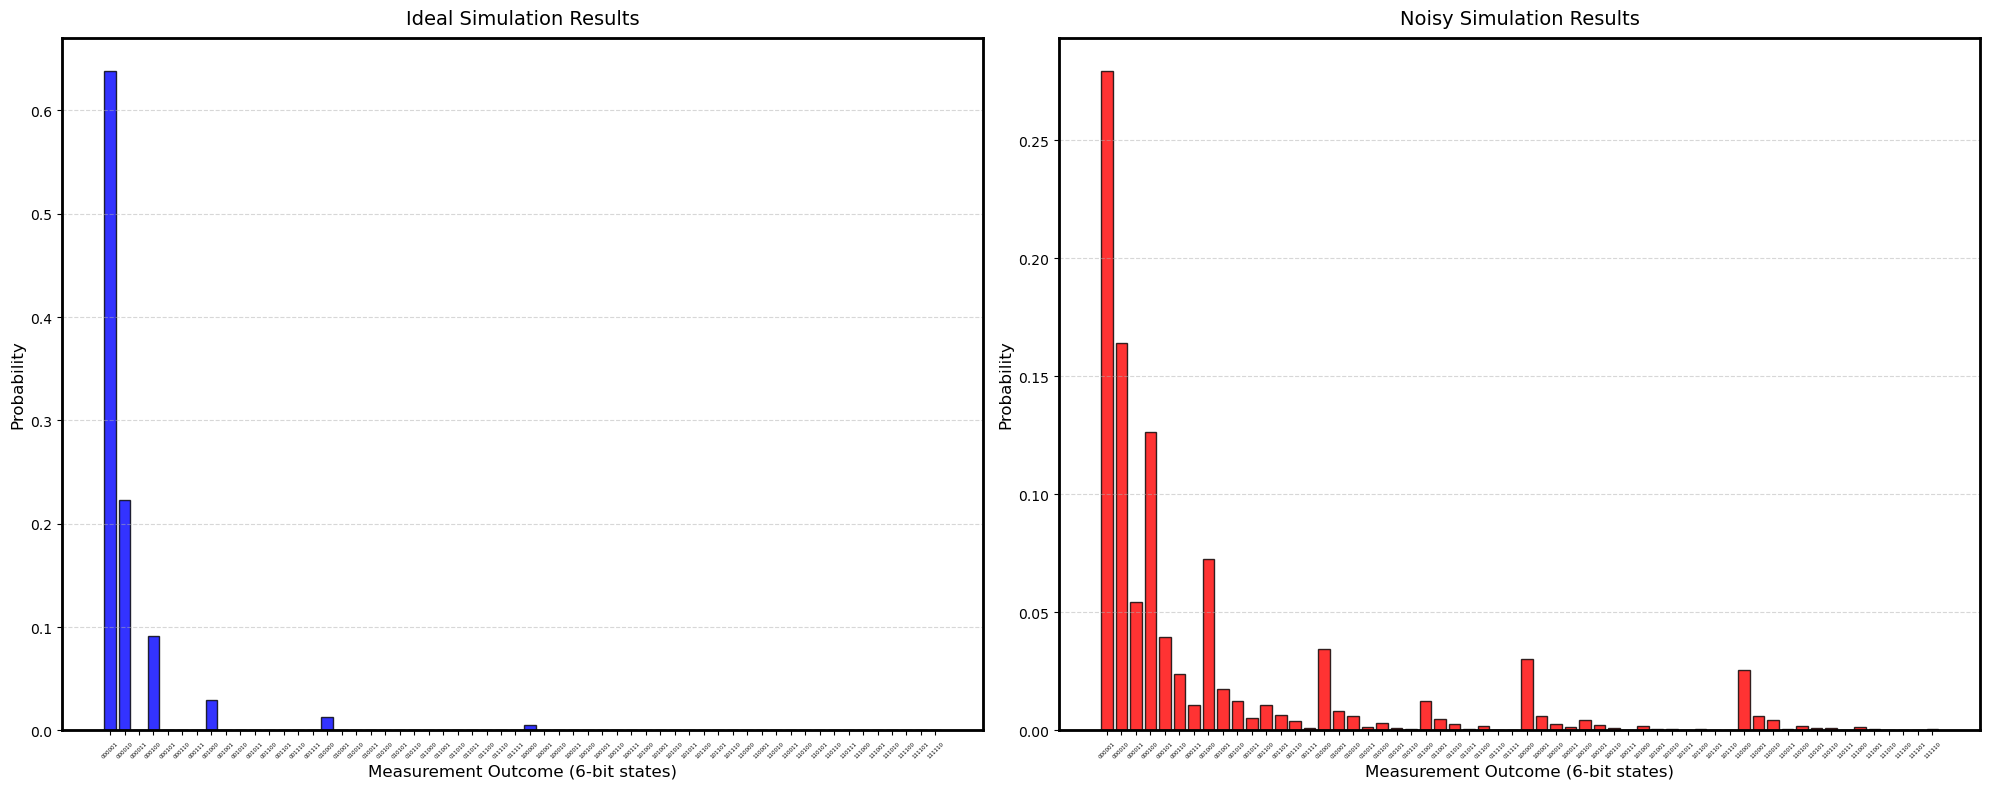

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeWashingtonV2
import matplotlib.pyplot as plt
import numpy as np


def build_quantum_exponential_distribution_circuit(num_qubits: int, decay: float) -> QuantumCircuit:
    """
    Constructs the quantum exponential distribution circuit using RX and CSWAP gates.
    
    Parameters:
        num_qubits (int): Number of qubits used for encoding the distribution.
        decay (float): Decay rate for exponential distribution.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    # Define quantum and classical registers
    q = QuantumRegister(num_qubits + 2, 'q')  # +2 for ancilla qubits: q[0] and q[num_qubits+1]
    c = ClassicalRegister(num_qubits, 'c')    # Classical bits to record measurements
    qc = QuantumCircuit(q, c)

    # Rotation angle to approximate exponential distribution
    theta = 2 * np.arccos(np.sqrt(decay / (1 + decay)))  # Example for different decay rates

    # Set the second qubit (q[1]) to |1⟩ as initial state
    qc.x(q[1])

    # Apply RX and CSWAP blocks to spread amplitude
    for block in range(1, num_qubits):
        qc.rx(theta, q[0])  # Apply RX gate on ancilla q[0]

        # Nested CSWAPs using q[num_qubits+1] as temporary ancilla
        for swap in range(1, block):
            qc.cswap(q[0], q[swap], q[num_qubits + 1])
            qc.reset(q[num_qubits + 1])

        # Final CSWAP step
        qc.cswap(q[0], q[block], q[block + 1])
        qc.reset(q[0])  # Reset main control ancilla q[0]

    # Measure q[1] through q[num_qubits] into classical register
    for i in range(1, num_qubits + 1):
        qc.measure(q[i], c[i - 1])

    return qc


def run_ideal_simulation(qc: QuantumCircuit, shots: int = 100000) -> dict:
    """
    Simulates the quantum circuit without noise and returns measurement results.
    """
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=shots).result()
    return result.get_counts(qc)


def run_noisy_simulation(qc: QuantumCircuit, shots: int = 1000) -> dict:
    """
    Runs the quantum simulation with a noise model from a fake backend.
    """
    # Load the fake backend
    fake_backend = FakeWashingtonV2()
    
    # Create noisy simulator from the fake backend
    noisy_simulator = AerSimulator.from_backend(fake_backend)
    
    # Transpile the circuit for the noisy backend
    compiled = transpile(qc, noisy_simulator)
    
    # Run the noisy simulation
    job = noisy_simulator.run(compiled, shots=shots)
    result = job.result()
    return result.get_counts(qc)


def calculate_probabilities(counts: dict, num_qubits: int) -> dict:
    """
    Calculates normalized measurement probabilities from counts,
    excluding the all-zero state and properly normalizing.
    """
    # Remove the all-zero state if present
    zero_state = '0' * num_qubits
    filtered_counts = {
        state: count for state, count in counts.items() if state != zero_state
    }

    total = sum(filtered_counts.values())
    return {
        state: count / total for state, count in filtered_counts.items()
    }


def plot_comparison(ideal_probs: dict, noisy_probs: dict, num_qubits: int):
    """
    Plots a comparison between ideal and noisy probability distributions using subplots
    with bordered boxes for better visual separation.
    """
    if not ideal_probs or not noisy_probs:
        print("No measurement outcomes to plot.")
        return

    # Get all possible states and sort them
    all_states = sorted(set(ideal_probs.keys()).union(set(noisy_probs.keys())), 
                    key=lambda x: int(x, 2))
    
    # Prepare data for plotting
    ideal_values = [ideal_probs.get(state, 0) for state in all_states]
    noisy_values = [noisy_probs.get(state, 0) for state in all_states]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Add boxes around each subplot
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_linewidth(2)  # Make borders thicker
            spine.set_color('black')  # Set border color
    
    # Plot ideal simulation
    ax1.bar(all_states, ideal_values, color='blue', alpha=0.8, edgecolor='black')
    ax1.set_xlabel(f"Measurement Outcome ({num_qubits}-bit states)", fontsize=12)
    ax1.set_ylabel("Probability", fontsize=12)
    ax1.set_title("Ideal Simulation Results", fontsize=14, pad=10)
    ax1.tick_params(axis='x', rotation=45, labelsize=4)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add a background rectangle for the plot area
    ax1.patch.set_edgecolor('black')  
    ax1.patch.set_linewidth(1)
    
    # Plot noisy simulation
    ax2.bar(all_states, noisy_values, color='red', alpha=0.8, edgecolor='black')
    ax2.set_xlabel(f"Measurement Outcome ({num_qubits}-bit states)", fontsize=12)
    ax2.set_ylabel("Probability", fontsize=12)
    ax2.set_title("Noisy Simulation Results", fontsize=14, pad=10)
    ax2.tick_params(axis='x', rotation=45, labelsize=4)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add a background rectangle for the plot area
    ax2.patch.set_edgecolor('black')  
    ax2.patch.set_linewidth(1)
    
    # Adjust layout with more padding
    plt.tight_layout()
    plt.show()


def main(num_qubits=8, decay=2.718, shots=10000):
    """
    Main execution function to simulate and plot both ideal and noisy versions.
    """
    qc = build_quantum_exponential_distribution_circuit(num_qubits, decay)
    
    print("Running ideal simulation...")
    ideal_counts = run_ideal_simulation(qc, shots)
    ideal_probs = calculate_probabilities(ideal_counts, num_qubits)
    
    print("\nMeasurement Probabilities (Ideal):")
    for state, prob in sorted(ideal_probs.items()):
        print(f"  State |{state}>: {prob:.4f}")

    print("\nRunning noisy simulation...")
    noisy_counts = run_noisy_simulation(qc, shots)
    noisy_probs = calculate_probabilities(noisy_counts, num_qubits)

    print("\nMeasurement Probabilities (Noisy):")
    for state, prob in sorted(noisy_probs.items()):
        print(f"  State |{state}>: {prob:.4f}")

    plot_comparison(ideal_probs, noisy_probs, num_qubits)


if __name__ == "__main__":
    main(num_qubits=6, decay=2.718, shots=10000)

# Optimization & Stochastic Uncertainty Analysis: Fidelity, Similarity


==================== Configuration:  ====================
Parameters: qubits=8, decay=2.718, shots=1000, tolerance=0.5, strict=True
=== Original Circuit ===
Original        Depth:   57, Size:   72, CX:    0

=== Stage 1: Custom Pre-optimization ===
TV Distance: 0.0265, KL Divergence: 0.0556
Pre-opt         Depth:   57, Size:   72, CX:    0
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 1) ===
TV Distance: 0.0547, KL Divergence: 0.0099
Level 1         Depth:  667, Size:  894, CX:  486
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 2) ===
TV Distance: 0.0606, KL Divergence: 0.0416
Level 2         Depth:  763, Size: 1242, CX:  393
✓ Distribution equivalence verified

=== Stage 2: Standard Transpilation (Level 3) ===
TV Distance: 0.0577, KL Divergence: 0.0391
Level 3         Depth:  763, Size: 1242, CX:  393
✓ Distribution equivalence verified

=== Stage 3: AI Transpilation ===

Mode: keep
TV Distance: 0.0495, KL Divergence

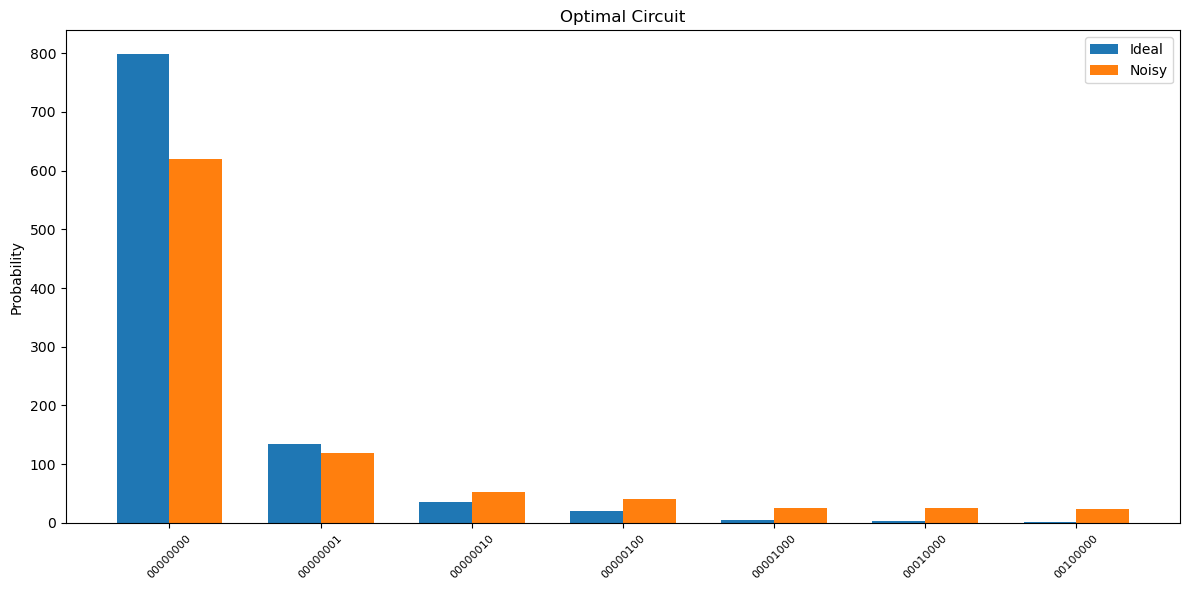

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeGeneva
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import Optimize1qGatesDecomposition, InverseCancellation, CommutativeCancellation
from qiskit.transpiler import PassManager
from qiskit.circuit.library import HGate, XGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Optional, List
from scipy.stats import entropy
import warnings

# Optional AI transpiler import
try:
    from qiskit_ibm_transpiler import generate_ai_pass_manager
    AI_TRANSPILER_AVAILABLE = True
except ImportError:
    AI_TRANSPILER_AVAILABLE = False
    print("Note: qiskit_ibm_transpiler not available. AI optimization will be skipped.")

# ==================================================================
# Circuit Construction Module
# ==================================================================

def build_quantum_exponential_distribution_circuit(num_qubits: int, decay: float = 0.5) -> QuantumCircuit:
    """Build a quantum circuit for exponential distribution generation."""
    q = QuantumRegister(num_qubits + 2, 'q')
    c = ClassicalRegister(num_qubits, 'c')
    qc = QuantumCircuit(q, c)

    theta = 2 * np.arccos(np.sqrt(decay / (1 + decay)))
    qc.x(q[1])

    for block in range(1, num_qubits):
        qc.rx(theta, q[0])
        for swap in range(1, block):
            qc.cswap(q[0], q[swap], q[num_qubits + 1])
            qc.reset(q[num_qubits + 1])
        qc.cswap(q[0], q[block], q[block + 1])
        qc.reset(q[0])

    for i in range(1, num_qubits + 1):
        qc.measure(q[i], c[i - 1])

    return qc

# ==================================================================
# Circuit Analysis Module
# ==================================================================

def get_circuit_metrics(circuit: QuantumCircuit) -> Tuple[int, int, int, int]:
    """Extract key metrics from a quantum circuit."""
    depth = circuit.depth()
    size = circuit.size()
    counts = circuit.count_ops()
    cx_count = counts.get('cx', 0) + counts.get('CX', 0)
    two_qubit_count = sum(counts.get(gate, 0) for gate in ['cx', 'CX', 'cz', 'CZ', 'swap', 'cswap'])
    return depth, size, cx_count, two_qubit_count

def print_circuit_metrics(name: str, circuit: QuantumCircuit):
    """Print formatted metrics for a circuit."""
    depth, size, cx_count, _ = get_circuit_metrics(circuit)
    print(f"{name:15} Depth: {depth:4}, Size: {size:4}, CX: {cx_count:4}")

# ==================================================================
# Optimization Passes Module
# ==================================================================

def create_custom_optimization_pass() -> PassManager:
    """Create a custom optimization pass manager for pre-processing."""
    pm = PassManager()
    pm.append(Optimize1qGatesDecomposition())
    pm.append(InverseCancellation([HGate(), XGate()]))
    pm.append(CommutativeCancellation())
    return pm

def create_standard_transpilation_passes(backend, opt_level: int) -> PassManager:
    """Create standard transpilation passes for a given optimization level."""
    return transpile(PassManager(), backend=backend, optimization_level=opt_level)

def create_ai_transpilation_passes(backend, mode: str) -> Optional[PassManager]:
    """Create AI-based transpilation passes if available."""
    if not AI_TRANSPILER_AVAILABLE:
        return None
    
    try:
        coupling_map_obj = CouplingMap(backend.configuration().coupling_map)
        return generate_ai_pass_manager(
            coupling_map=coupling_map_obj,
            ai_optimization_level=3,
            optimization_level=3,
            ai_layout_mode=mode,
        )
    except Exception as e:
        print(f"AI transpilation setup failed: {e}")
        return None

# ==================================================================
# Circuit Verification Module
# ==================================================================

def compute_distribution_similarity(counts1: dict, counts2: dict, shots: int, 
                                  tolerance: float = 0.05) -> Tuple[float, bool]:
    """Compare two probability distributions using multiple metrics."""
    # Remove all-zero state and normalize
    def process_counts(counts, num_qubits):
        zero_state = '0'*num_qubits
        filtered = {k: v for k, v in counts.items() if k != zero_state}
        total = sum(filtered.values())
        return {k: v/total for k, v in filtered.items()}
    
    num_qubits = len(next(iter(counts1.keys()))) if counts1 else 0
    prob1 = process_counts(counts1, num_qubits)
    prob2 = process_counts(counts2, num_qubits)
    
    all_keys = set(prob1.keys()).union(set(prob2.keys()))
    prob1_vec = np.array([prob1.get(k, 0) for k in sorted(all_keys)])
    prob2_vec = np.array([prob2.get(k, 0) for k in sorted(all_keys)])
    
    fidelity = np.sum(np.sqrt(prob1_vec * prob2_vec))**2
    tv_distance = 0.5 * np.sum(np.abs(prob1_vec - prob2_vec))
    
    epsilon = 1e-10
    prob1_smooth = prob1_vec + epsilon
    prob2_smooth = prob2_vec + epsilon
    prob1_smooth /= np.sum(prob1_smooth)
    prob2_smooth /= np.sum(prob2_smooth)
    
    kl_div = 0.5 * (entropy(prob1_smooth, prob2_smooth) + entropy(prob2_smooth, prob1_smooth))
    
    similarity = fidelity * (1 - tv_distance) / (1 + kl_div)
    is_equivalent = (
        fidelity >= (1 - tolerance) and
        tv_distance <= tolerance and
        kl_div <= tolerance
    )
    
    print(f"TV Distance: {tv_distance:.4f}, KL Divergence: {kl_div:.4f}")
    return similarity, is_equivalent

def verify_circuit_equivalence(original_circuit: QuantumCircuit, 
                             optimized_circuit: QuantumCircuit,
                             shots: int = 2000,
                             tolerance: float = 0.05) -> Tuple[bool, Dict]:
    """Verify that two circuits produce equivalent probability distributions."""
    simulator = AerSimulator()
    
    try:
        orig_compiled = transpile(original_circuit, simulator)
        opt_compiled = transpile(optimized_circuit, simulator)
        
        orig_job = simulator.run(orig_compiled, shots=shots)
        opt_job = simulator.run(opt_compiled, shots=shots)
        
        orig_counts = orig_job.result().get_counts()
        opt_counts = opt_job.result().get_counts()
        
        similarity, is_equivalent = compute_distribution_similarity(
            orig_counts, opt_counts, shots, tolerance
        )
        
        return is_equivalent, {
            'is_equivalent': is_equivalent,
            'similarity_score': similarity,
            'original_counts': orig_counts,
            'optimized_counts': opt_counts,
            'tolerance_used': tolerance
        }
        
    except Exception as e:
        print(f"Verification failed: {e}")
        return False, {'error': str(e)}

# ==================================================================
# Evaluation and Analysis Module
# ==================================================================

def evaluate_circuit(circuit: QuantumCircuit, 
                    noise_model: NoiseModel,
                    shots: int = 1000) -> Dict:
    """Evaluate a single circuit with both ideal and noisy simulations."""
    sim_ideal = AerSimulator()
    sim_noisy = AerSimulator(noise_model=noise_model)
    
    try:
        ideal_compiled = transpile(circuit, sim_ideal)
        ideal_job = sim_ideal.run(ideal_compiled, shots=shots)
        ideal_counts = ideal_job.result().get_counts(circuit)
        
        noisy_compiled = transpile(circuit, sim_noisy)
        noisy_job = sim_noisy.run(noisy_compiled, shots=shots)
        noisy_counts = noisy_job.result().get_counts(circuit)
        
        # Process counts to remove all-zero state and normalize
        def process_counts(counts, num_qubits):
            zero_state = '0'*num_qubits
            filtered = {k: v for k, v in counts.items() if k != zero_state}
            total = sum(filtered.values())
            return {k: v/total for k, v in filtered.items()}
        
        num_qubits = len(next(iter(ideal_counts.keys()))) if ideal_counts else 0
        ideal_probs = process_counts(ideal_counts, num_qubits)
        noisy_probs = process_counts(noisy_counts, num_qubits)
        
        all_keys = set(ideal_probs.keys()).union(noisy_probs.keys())
        ideal_vec = np.array([ideal_probs.get(k, 0) for k in sorted(all_keys)])
        noisy_vec = np.array([noisy_probs.get(k, 0) for k in sorted(all_keys)])
        
        fidelity = np.sum(np.sqrt(ideal_vec * noisy_vec))**2
        
        return {
            'ideal_counts': ideal_counts,
            'noisy_counts': noisy_counts,
            'processed_ideal': ideal_probs,
            'processed_noisy': noisy_probs,
            'fidelity': fidelity
        }
        
    except Exception as e:
        print(f"Simulation failed: {e}")
        return {'error': str(e)}

def evaluate_all_circuits(circuits_dict: Dict, 
                        noise_model: NoiseModel,
                        shots: int = 1000) -> Dict:
    """Evaluate all circuits in a dictionary."""
    evaluation_results = {}
    
    for name, result in circuits_dict.items():
        if 'circuit' not in result:
            continue
            
        print(f"\n--- Evaluating {name} ---")
        eval_result = evaluate_circuit(result['circuit'], noise_model, shots)
        
        if 'fidelity' in eval_result:
            evaluation_results[name] = {
                **result,
                **eval_result
            }
            print(f"Fidelity: {eval_result['fidelity']:.4f}")
    
    return evaluation_results

def find_optimal_circuit(evaluation_results: Dict) -> Tuple[str, Dict]:
    """Find the optimal circuit based on a composite score."""
    best_name = None
    best_score = -1
    
    print("\n=== Circuit Comparison ===")
    print("Name\t\tFidelity\tDepth\tCX\tScore")
    print("-" * 50)
    
    for name, result in evaluation_results.items():
        fidelity = result.get('fidelity', 0)
        depth = result.get('depth', 0)
        cx_count = result.get('cx_count', 0)
        
        score = fidelity - 0.01 * depth - 0.005 * cx_count
        
        print(f"{name:15}\t{fidelity:.4f}\t\t{depth}\t{cx_count}\t{score:.4f}")
        
        if score > best_score:
            best_score = score
            best_name = name
    
    if best_name:
        print(f"\nOptimal circuit: {best_name} (Score: {best_score:.4f})")
        return best_name, evaluation_results[best_name]
    else:
        print("\nNo optimal circuit found!")
        return None, {}

def plot_comparison(evaluation_results: Dict, optimal_name: str):
    """Plot comparison of ideal vs noisy results for the optimal circuit."""
    if optimal_name not in evaluation_results:
        return
        
    result = evaluation_results[optimal_name]
    ideal = result['ideal_counts']
    noisy = result['noisy_counts']
    
    labels = sorted(ideal.keys())
    ideal_vals = [ideal.get(k, 0) for k in labels]
    noisy_vals = [noisy.get(k, 0) for k in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, ideal_vals, width, label='Ideal')
    rects2 = ax.bar(x + width/2, noisy_vals, width, label='Noisy')
    
    ax.set_ylabel('Probability')
    ax.set_title(f'Optimal Circuit')
    ax.set_xticks(x)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# ==================================================================
# Optimization Stages Module 
# ==================================================================

def run_pre_optimization(original_circuit: QuantumCircuit, 
                        strict_mode: bool,
                        verification_shots: int,
                        tolerance: float) -> Tuple[QuantumCircuit, Dict]:
    """Run custom pre-optimization stage."""
    print("\n=== Stage 1: Custom Pre-optimization ===")
    try:
        custom_pm = create_custom_optimization_pass()
        qc_pre_opt = custom_pm.run(original_circuit.copy())
        
        is_valid, verification_result = verify_circuit_equivalence(
            original_circuit, qc_pre_opt, verification_shots, tolerance
        )
        
        if is_valid or not strict_mode:
            print_circuit_metrics("Pre-opt", qc_pre_opt)
            if is_valid:
                print("✓ Distribution equivalence verified")
            else:
                print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
            return qc_pre_opt, verification_result
        else:
            print("✗ Pre-optimization rejected due to distribution changes")
            return original_circuit, verification_result
            
    except Exception as e:
        print(f"Pre-optimization failed: {e}")
        return original_circuit, {'error': str(e)}

def run_standard_transpilation(pre_opt_circuit: QuantumCircuit, 
                             original_circuit: QuantumCircuit,
                             backend,
                             strict_mode: bool,
                             verification_shots: int,
                             tolerance: float) -> Dict:
    """Run standard transpilation optimization stages."""
    valid_results = {}
    
    for opt_level in [1, 2, 3]:
        print(f"\n=== Stage 2: Standard Transpilation (Level {opt_level}) ===")
        try:
            qc_transpiled = transpile(
                pre_opt_circuit.copy(),
                backend=backend,
                optimization_level=opt_level,
                seed_transpiler=42
            )
            
            is_valid, verification_result = verify_circuit_equivalence(
                original_circuit, qc_transpiled, verification_shots, tolerance
            )
            
            if is_valid or not strict_mode:
                print_circuit_metrics(f"Level {opt_level}", qc_transpiled)
                if is_valid:
                    print("✓ Distribution equivalence verified")
                else:
                    print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
                
                depth, size, cx_count, _ = get_circuit_metrics(qc_transpiled)
                valid_results[f'standard_L{opt_level}'] = {
                    'circuit': qc_transpiled, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            else:
                print("✗ Standard transpilation rejected due to distribution changes")
                
        except Exception as e:
            print(f"Standard transpilation level {opt_level} failed: {e}")
    
    return valid_results

def run_ai_transpilation(pre_opt_circuit: QuantumCircuit,
                        original_circuit: QuantumCircuit,
                        backend,
                        strict_mode: bool,
                        verification_shots: int,
                        tolerance: float) -> Dict:
    """Run AI-enhanced transpilation if available."""
    valid_results = {}
    
    if not AI_TRANSPILER_AVAILABLE:
        print("\n=== Stage 3: AI Transpilation (Skipped) ===")
        print("AI transpilation not available")
        return valid_results
    
    print("\n=== Stage 3: AI Transpilation ===")
    ai_modes = ['keep', 'improve', 'optimize']
    
    for mode in ai_modes:
        print(f"\nMode: {mode}")
        try:
            ai_pass_manager = create_ai_transpilation_passes(backend, mode)
            if ai_pass_manager is None:
                continue
                
            qc_ai_opt = ai_pass_manager.run(pre_opt_circuit.copy())
            
            is_valid, verification_result = verify_circuit_equivalence(
                original_circuit, qc_ai_opt, verification_shots, tolerance
            )
            
            if is_valid or not strict_mode:
                print_circuit_metrics(f"AI {mode}", qc_ai_opt)
                if is_valid:
                    print("✓ Distribution equivalence verified")
                else:
                    print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
                
                depth, size, cx_count, _ = get_circuit_metrics(qc_ai_opt)
                valid_results[f'ai_{mode}'] = {
                    'circuit': qc_ai_opt, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            else:
                print("✗ AI transpilation rejected due to distribution changes")
                
        except Exception as e:
            print(f"AI transpilation with mode '{mode}' failed: {e}")
    
    return valid_results

def run_hybrid_optimization(valid_optimizations: Dict,
                          original_circuit: QuantumCircuit,
                          backend,
                          strict_mode: bool,
                          verification_shots: int,
                          tolerance: float) -> Dict:
    """Run hybrid optimization combining best results."""
    print("\n=== Stage 4: Hybrid Optimization ===")
    
    if not valid_optimizations:
        print("No valid circuits available for hybrid optimization")
        return {}
    
    # Find best circuit for hybrid optimization
    best_circuit = None
    best_score = float('inf')
    
    for name, result in valid_optimizations.items():
        score = result['depth'] + result['cx_count']
        if score < best_score:
            best_score = score
            best_circuit = result['circuit']
    
    if best_circuit is None:
        return {}
    
    try:
        qc_hybrid = transpile(
            best_circuit.copy(),
            backend=backend,
            optimization_level=2,
            seed_transpiler=42
        )
        
        is_valid, verification_result = verify_circuit_equivalence(
            original_circuit, qc_hybrid, verification_shots, tolerance
        )
        
        if is_valid or not strict_mode:
            print_circuit_metrics("Hybrid", qc_hybrid)
            if is_valid:
                print("✓ Distribution equivalence verified")
            else:
                print(f"⚠ Distribution equivalence failed (similarity: {verification_result.get('similarity_score', 0):.4f}")
            
            depth, size, cx_count, _ = get_circuit_metrics(qc_hybrid)
            return {
                'hybrid': {
                    'circuit': qc_hybrid, 
                    'depth': depth, 
                    'size': size, 
                    'cx_count': cx_count,
                    'verification': verification_result
                }
            }
        else:
            print("✗ Hybrid optimization rejected due to distribution changes")
            return {}
            
    except Exception as e:
        print(f"Hybrid optimization failed: {e}")
        return {}

# ==================================================================
# Main Optimization Function
# ==================================================================

def constrained_multi_stage_optimization(
    qc: QuantumCircuit, 
    backend,
    verification_shots: int = 2000,
    tolerance: float = 0.05,
    execution_shots: int = 1000,
    strict_mode: bool = True
) -> Tuple[Dict, NoiseModel, Dict]:
    """Multi-stage optimization with distributional equivalence constraints."""
    results = {}
    verification_log = {}
    noise_model = NoiseModel.from_backend(backend)
    
    depth, size, cx_count, _ = get_circuit_metrics(qc)
    results['original'] = {
        'circuit': qc, 
        'depth': depth, 
        'size': size, 
        'cx_count': cx_count
    }
    
    print("=== Original Circuit ===")
    print_circuit_metrics("Original", qc)
    
    qc_pre_opt, pre_opt_log = run_pre_optimization(
        qc, strict_mode, verification_shots, tolerance
    )
    verification_log['pre_opt'] = pre_opt_log
    
    if 'error' not in pre_opt_log and (pre_opt_log.get('is_equivalent', False) or not strict_mode):
        depth, size, cx_count, _ = get_circuit_metrics(qc_pre_opt)
        results['pre_opt'] = {
            'circuit': qc_pre_opt, 
            'depth': depth, 
            'size': size, 
            'cx_count': cx_count
        }
    
    standard_results = run_standard_transpilation(
        qc_pre_opt, qc, backend, strict_mode, verification_shots, tolerance
    )
    results.update(standard_results)
    verification_log.update({k: v['verification'] for k, v in standard_results.items()})
    
    ai_results = run_ai_transpilation(
        qc_pre_opt, qc, backend, strict_mode, verification_shots, tolerance
    )
    results.update(ai_results)
    verification_log.update({k: v['verification'] for k, v in ai_results.items()})
    
    hybrid_results = run_hybrid_optimization(
        {**standard_results, **ai_results},
        qc,
        backend,
        strict_mode,
        verification_shots,
        tolerance
    )
    results.update(hybrid_results)
    verification_log.update({k: v['verification'] for k, v in hybrid_results.items()})
    
    print(f"\n=== Optimization Summary ===")
    print(f"Total valid circuits: {len(results)}")
    print(f"Strict mode: {'ON' if strict_mode else 'OFF'}")
    
    return results, noise_model, verification_log

# ==================================================================
# Main Execution Functions
# ==================================================================

def run_single_configuration(
    num_qubits: int = 6,
    decay: float = 0.5,
    verification_shots: int = 2000,
    execution_shots: int = 1000,
    tolerance: float = 0.05,
    strict_mode: bool = True,
    config_name: str = ""
):
    """Run optimization with a single configuration."""
    print(f"\n{'='*20} Configuration: {config_name} {'='*20}")
    print(f"Parameters: qubits={num_qubits}, decay={decay}, shots={execution_shots}, "
          f"tolerance={tolerance}, strict={strict_mode}")
    
    backend = FakeGeneva()
    qc = build_quantum_exponential_distribution_circuit(num_qubits, decay)
    
    valid_circuits, noise_model, verification_log = constrained_multi_stage_optimization(
        qc, backend, verification_shots, tolerance, execution_shots, strict_mode
    )
    
    if valid_circuits:
        evaluation_results = evaluate_all_circuits(valid_circuits, noise_model, execution_shots)
        
        if evaluation_results:
            optimal_name, optimal_result = find_optimal_circuit(evaluation_results)
            
            print(f"\n=== Verification Summary ===")
            for name, log in verification_log.items():
                if 'similarity_score' in log:
                    equiv_status = "✓" if log['is_equivalent'] else "✗"
                    print(f"{name}: {equiv_status} Similarity = {log['similarity_score']:.4f}")
            
            plot_comparison(evaluation_results, optimal_name)
            
            return valid_circuits, evaluation_results, optimal_name
        else:
            print("No circuits successfully evaluated.")
            return valid_circuits, {}, None
    else:
        print("No valid optimized circuits found!")
        return {}, {}, None

def main():
    """Main function to run multiple configurations."""
    print("=== Constrained Quantum Circuit Optimization ===\n")
    
    configurations = [
        {"num_qubits": 6, "decay": 0.5, "tolerance": 0.03, "strict_mode": True, "name": "Strict (3% tolerance)"},
        {"num_qubits": 6, "decay": 0.5, "tolerance": 0.05, "strict_mode": False, "name": "Permissive (5% tolerance)"},
    ]
    
    for config in configurations:
        try:
            run_single_configuration(**config)
        except Exception as e:
            print(f"Configuration {config['name']} failed: {e}")
        print("\n" + "="*80)

if __name__ == "__main__":
    run_single_configuration(
        num_qubits=8,
        decay=2.718,
        verification_shots=2000,
        execution_shots=1000,
        tolerance=0.5,
        strict_mode=True,
    )